# Import Dependencies

In [99]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

# Process Data

In [23]:
# import data
DF = pd.DataFrame(columns = ['target'] + [f'pixel_{x}' for x in range(28*28)])
for name in ['mnist_train', 'mnist_test']:
    file = f"../../data/{name}.csv"
    df = pd.read_csv(file, names=['target'] + [f'pixel_{x}' for x in range(28*28)])
    DF = DF.append(df, ignore_index=True, sort=False)

In [24]:
# separate targets from the features
targets = DF.target
DF.drop('target', axis=1, inplace=True)

# Functions

In [143]:
def accuracy(y, yhat):
    return np.mean(y == yhat)

def onehot(y, K):
    N = y.size
    Y = np.zeros((N,K))
    for i in range(y):
        Y[i,y[i]] = 1
    return Y

def confusion_matrix(y, yhat, K=10):
    return (onehot(y,K).T @ onehot(yhat,K)).astype(np.int32)

# Class Definition

In [144]:
class ANN(nn.Module):
    
    def __init__(self, targets, features, **kwargs):
        super().__init__()
        
        # save targets and features DF
        self.targets = targets
        self.DF = features
        
        # find the number of classifications
        self.K = targets.unique().shape[0]
        
        # find the numbers of observations for the train-validate-test sets
        N,self.D = DF.shape
        N_train = int(N * 0.60)
        N_validate = int(N * 0.20)
        self.N = {
            'total'    : N,
            'train'    : N_train,
            'validate' : N_validate,
            'test'     : N - N_train - N_validate 
        }
        
        # save 
        indices = np.arange(N)
        np.random.RandomState(seed=0).shuffle(indices)
        self.indices = {
            'total'    : indices,
            'train'    : indices[ : N_train ],
            'validate' : indices[ N_train : N_train + N_validate ],
            'test'     : indices[ N_train + N_validate : ]
        }
        
        self.__construc_model(**kwargs)
        
        # model
        self.model = nn.Sequential(
            
            # hiddden layer 1
            nn.Linear(self.D, self.M[1]),
            self.f[1],
            nn.Dropout(p=self.p[1]),
            
            # hidden layer 2
            nn.Linear(self.M[1], self.M[2]),
            self.f[2],
            nn.Dropout(p=self.p[2]),
            
            # output layer
            nn.Linear(self.M[2], self.K)
        )
        
        # optimizer
        self.optimizer = torch.optim.RMSprop(
            self.model.parameters(),
            lr = self.learning_rate,
            alpha = self.alpha,
            eps = 1e-08,
            weight_decay = self.lambda2,
            momentum = self.momentum,
            centered = False,
        )
        
        # loss function
        self.loss_function = nn.CrossEntropyLoss()
        
    def __construc_model(self, **kwargs):
        
        # layer attributes
        self.L = kwargs['L'] if 'L' in kwargs else 2
        # number of nodes in each hidden layer
        self.M = kwargs['M'] if 'M' in kwargs else {1:500, 2:300}
        # activation functions
        self.f = kwargs['f'] if 'f' in kwargs else {1:nn.LeakyReLU(), 2:nn.LeakyReLU()}
        # dropout probabilites
        self.p = kwargs['p'] if 'p' in kwargs else {1:.5, 2:.5}
        
        # optimization attributes
        self.learning_rate = kwargs['learning_rate'] if 'learning_rate' in kwargs else 1e-3
        # alpha
        self.alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.99
        # lambda2
        self.lambda2 = kwargs['lambda2'] if 'lambda2' in kwargs else 0
        # momentum 
        self.momentum = kwargs['momentum'] if 'momentum' in kwargs else .9
        
        # fitting attributes
        self.batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 50
        
    def __get_batch(self,idx):
        
        try:
            len(idx)
        except:
            idx = [idx]
        
        # get feature and target tensors
        T = torch.from_numpy( self.DF[self.DF.index.isin(idx)].to_numpy(dtype=np.float32) ).type(torch.float32)
        y = torch.from_numpy( self.targets.loc[idx].to_numpy(dtype=np.float32) ).type(torch.float32)
        
        return y.long(),T
        
    def fit(self, epochs=1):
        
        batches = self.N['train']//self.batch_size
        
        for _ in tqdm(range(int(epochs)), leave=False):
            
            indices = self.indices['train'].copy()
            np.random.shuffle(indices)
            LOSS = np.zeros(batches)
            
            for batch in tqdm(range(batches), leave=False):
                
                idx = indices[ batch*self.batch_size : (batch+1)*self.batch_size ]
                y,T = self.__get_batch(idx)
                H = self.model(T)
                
                try:
                    loss = self.loss_function(H,y)
                except:
                    pdb.set_trace()
                LOSS[batch] = loss.item()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            if not hasattr(self, "LOSS"):
                self.LOSS = LOSS.reshape([1,batches])
            else:
                self.LOSS = np.vstack( (self.LOSS, LOSS) )
    
    def predict(self):
        self.predictions = pd.Series(index=self.targets.index)
        for i in tqdm(range(self.N['total']), leave=False):
            
            y,T = self.__get_batch(i)
            H = self.model(T)
            eH = torch.exp(H)
            self.predictions[i] = torch.log( eH / eH.sum() ).argmax().item()
    
    def plot_loss(self):
        
        fig,ax = plt.subplots(nrows=2, figsize=(10,10))
        N1,N2 = self.LOSS.shape
        
        ax[0].set_title("Total Loss Over All Training Sessions", fontsize=20)
        ax[0].plot(self.LOSS.flatten(), linewidth=2)
        for i in range(N1+1):
            ax[0].vlines(i*N2, self.LOSS.min(), self.LOSS.max(), color='r', linestyles='dashed')
        
        ax[1].set_title("Loss For Most Recent Training Epoch", fontsize=20)
        ax[1].plot(self.LOSS[-1,:], linewidth=2)
        
        fig.text(0.5, 0.04, 'Iterations', ha='center', va='center', fontsize=20)
        fig.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical', fontsize=20)
    
    def evaluate_model(self):
        
        self.accuracy = {}
        self.confusion_matrix = {}
        
        for key in ['train', 'validate', 'test']:
            
            idx = self.indices[key]
            y = self.targets.loc[idx].to_numpy(dtype=np.int32)
            yhat = self.predictions.loc[idx].to_numpy(dtype=np.int32)
            
            self.accuracy[key] = accuracy(y,yhat)
            self.confusion_matrix[key] = confusion_matrix(y,yhat)

In [145]:
model = ANN(targets, DF, learning_rate=1e-4)

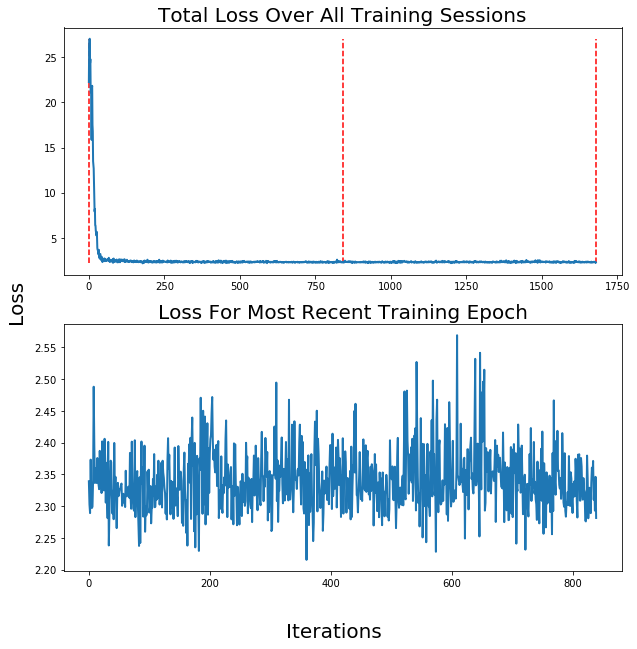

In [146]:
model.fit(epochs=2)
model.plot_loss()

In [147]:
model.predict()
model.evaluate_model()

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
acc = model.accuracy
print("train: {:0.4f}, validate: {:0.4f}".format(acc['train'],acc['validate']))

In [ ]:
model.confusion_matrix['validate']